In [1]:
import LLMSR
import openai

import numpy as np
import matplotlib.pyplot as plt

In [2]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)

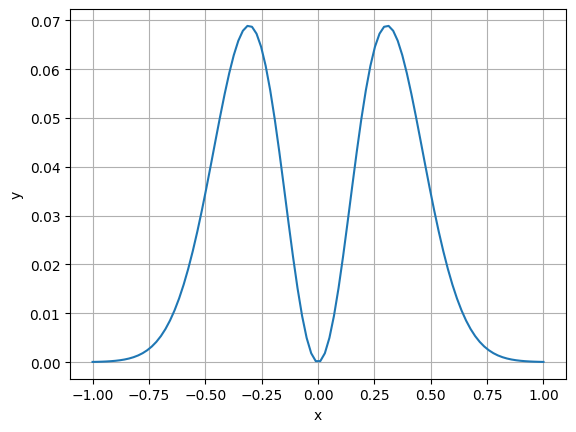

In [3]:
x = np.linspace(-1, 1, 100)
y = x*np.sin(2*x)*np.exp(-10 * x**2)
#y = np.tanh(3*x)

plt.plot(x, y,label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
#plt.legend()
plt.savefig('plot.png')

# Getting the Base64 string
base64_image = LLMSR.encode_image('plot.png')

In [4]:
r = LLMSR.single_call(client, base64_image, x, y, model="openai/gpt-4o-mini",function_list=None, system_prompt=None)
print(r)

{'params': array([0.48577268, 9.1482465 , 0.0251029 ]), 'score': np.float64(-0.024597175123010087), 'ansatz': 'np.exp(-params[0] * (x - params[1])**2) + params[2]', 'Num_params': 3, 'response': ChatCompletion(id='gen-1739984293-N22Amm4pTPF3ZN48JtHz', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='```python\nnp.exp(-params[0] * (x - params[1])**2) + params[2]\n```', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), native_finish_reason='stop')], created=1739984293, model='openai/gpt-4o-mini', object='chat.completion', service_tier=None, system_fingerprint='fp_13eed4fce1', usage=CompletionUsage(completion_tokens=28, prompt_tokens=664, total_tokens=692, completion_tokens_details=None, prompt_tokens_details=None), provider='OpenAI'), 'prompt': 'import numpy as np \ncurve_0 = lambda x,*params: x* params[0] + params[1] \ncurve_1 = lambda x,*params:', 'function_list': None}


/Users/trharvey/llm/lib/python3.13/site-packages/LLMSR/llmSR.py:88: OptimizeWarning: Covariance of the parameters could not be estimated
  params_opt, _ = curve_fit(curve, x, y, p0=params_initial)


In [ ]:
population_size = 10
num_of_generations = 5
start = LLMSR.check_key_limit(client)
res = LLMSR.run_genetic(client, base64_image, x, y, population_size,num_of_generations, 
                        temperature=1., model="openai/gpt-4o", system_prompt=None, elite=False)
print(f"Credits spent: {start - LLMSR.check_key_limit(client)}")

Generating Initial population population


100%|██████████| 20/20 [01:19<00:00,  3.98s/it]


Best score:  -8.349886856606228e-08
Best ansatz:   np.sin(params[0] * x)**2 * np.exp(-params[1] * x**2)
Best params:  [ 1.41492419 10.01581574]
Exit condition met.
Credits spent: 0.045543899999998416


In [6]:
len(res[0])

20

In [7]:
highest_score_element = max((item for sublist in res for item in sublist), key=lambda item: item['score'])
print(highest_score_element['ansatz'])

 np.sin(params[0] * x)**2 * np.exp(-params[1] * x**2)


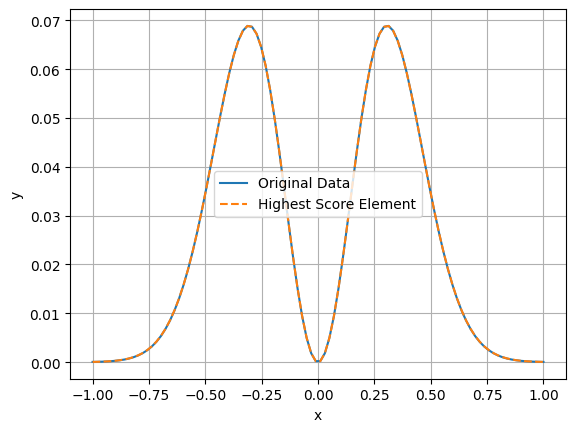

In [8]:
# Extract the parameters and the ansatz function from the highest_score_element
params = highest_score_element['params']
ansatz = highest_score_element['ansatz']

# Define the ansatz function
def ansatz_function(x, params):
    return eval(ansatz)

# Plot the original data
plt.plot(x, y, label='Original Data')

# Plot the highest score element
plt.plot(x, ansatz_function(x, params), label='Highest Score Element', linestyle='--')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

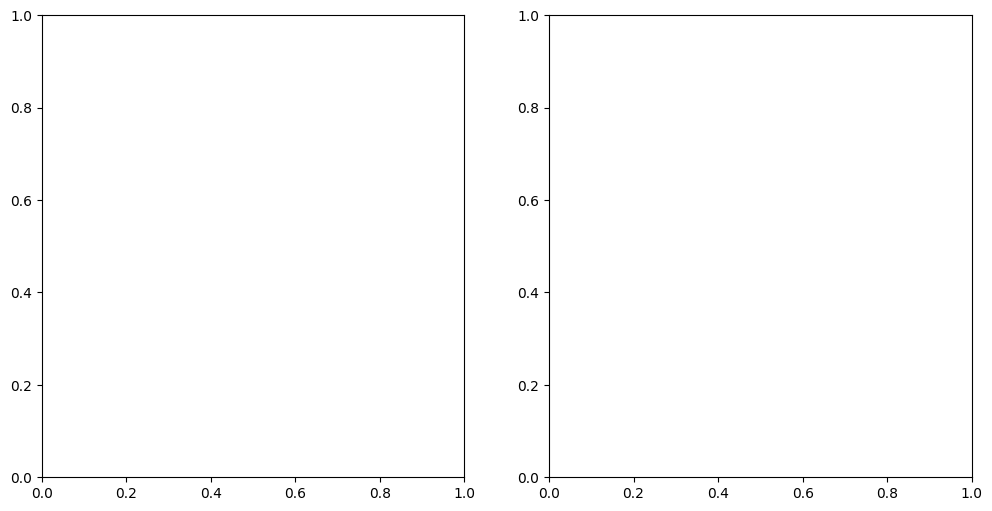

In [9]:
# Remove infinite scores
filtered_res = [[ind for ind in generation if np.isfinite(ind['score'])] for generation in res]

# Extract fitness scores from the filtered results
average_fitness = [np.mean([ind['score'] for ind in generation]) for generation in filtered_res]
best_fitness = [max([ind['score'] for ind in generation]) for generation in filtered_res]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the average fitness
axs[0].plot(range(num_of_generations), average_fitness, label='Average Fitness')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Fitness Score')
axs[0].legend()
axs[0].grid(True)

# Plot the best fitness
axs[1].plot(range(num_of_generations), best_fitness, label='Best Fitness', linestyle='--')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Fitness Score')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()